<a href="https://colab.research.google.com/github/Bonorinoa/LangGraph-Crash-Course/blob/main/Lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install langgraph langsmith langchain_groq langchain_core langchain_community --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 148.7/148.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.7/412.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 31.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.8/109.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.7/44.7 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 2.2 MB/s eta 0:00:00


## 2. Tools and ReAct Agent

In the context of LangChain, a Tool is essentially a Python function accompanied by a JSON schema that acts as a detailed description of its operation. This schema tells the language model (LLM) when and how to use the tool, including information about its name, description, and the arguments it expects to receive. Tools are fundamental because they allow language models to interact with specific functions and execute concrete tasks in our code, which makes it easier to predict and explain the workflow outcome.

In LangGraph, Tools are implemented as special nodes (i.e., Python functions) that often receive a string as input and return a string as output. The string is desirable when working with LLMs, but keep in mind that your tools can return any data structure you wish.

Since a Tool is any Python function, creativity is often the only limit when designing them. Common examples include API calls, mathematical operations, code compilation, or even using another LLM to evaluate some generated result.

The ability to call tools is what differentiates normal chatbots from Agents, it's what gives autonomy to the LLM. However, this ability to call tools is far from perfect. Even models fine-tuned for tool use, like Groq's Llama 3, struggle with complex queries. The development process requires patience and a good amount of experimentation at this stage of the technology.

When designing tools to be used by models, keep in mind the following:

- Tools that are well-named, properly documented, and with appropriately defined data types are easier for models to use.
- Design simple tools with specific scope, as they are more likely to be used correctly by models.
- Use chat models that support tool-calling APIs to make the most of their functionality.

There's no better way to learn than by doing, so let's get to work.

**References:**

[LangChain docs](https://python.langchain.com/docs/concepts/tools/)

[Tools blog](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/)

[Tool node](https://langchain-ai.github.io/langgraph/how-tos/tool-calling/)

[Handling Tool calling errors](https://langchain-ai.github.io/langgraph/how-tos/tool-calling-errors/)

[tool decorator docs](https://python.langchain.com/api_reference/core/tools/langchain_core.tools.convert.tool.html)


In [ ]:
from langgraph.graph import Graph, StateGraph, START, END, MessagesState
from langchain_groq import ChatGroq

from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage # message abstraction
import operator

import os, getpass
from IPython.display import Image, display

# utility to visualize the workflow created
def visualize_workflow(workflow):
    display(Image(workflow.get_graph().draw_mermaid_png()))

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


### The @tool Decorator

To create a custom Tool, we can use the @tool decorator provided by LangChain, which significantly simplifies the creation process. This decorator transforms any Python function into a LangChain BaseTool object, automatically inferring the name, description, and expected arguments of the function. Additionally, it allows us to customize these elements if desired, and offers additional features such as the ability to return artifacts (like images or dataframes) and the possibility to hide input arguments from the schema that the model sees.


In [ ]:
from langchain_core.tools import tool
import pprint as pp

# remember to include a docstring for the function
@tool
def testTool(name: str, age: int) -> str:

    """
    This is a test tool that returns a greeting given the user's name and age.
    """

    return f"Hello {name}, you are {age} years old"

# Attributes generated by the decorator
pp.pprint(testTool.__dict__) # dictionary with the tool's attributes
print("---------------------")
print(testTool.name) # tool's name
print(testTool.description) # tool's description
print(testTool.args) # tool's arguments
print("---------------------")
print(testTool.invoke({"name":"Juan", "age":25})) # execution/invocation of the tool, note we pass a dictionary where the keys are the tool's arguments

{'args_schema': <class 'langchain_core.utils.pydantic.testTool'>,
 'callback_manager': None,
 'callbacks': None,
 'coroutine': None,
 'description': "This is a test tool that returns a greeting given the user's "
                'name and age.',
 'func': <function testTool at 0x7841d898efc0>,
 'handle_tool_error': False,
 'handle_validation_error': False,
 'metadata': None,
 'name': 'testTool',
 'response_format': 'content',
 'return_direct': False,
 'tags': None,
 'verbose': False}
---------------------
testTool
This is a test tool that returns a greeting given the user's name and age.
{'name': {'title': 'Name', 'type': 'string'}, 'age': {'title': 'Age', 'type': 'integer'}}
---------------------
Hello Juan, you are 25 years old


In [ ]:
# we can pass annotated attributes or predefined schemas
from typing import Annotated, List

@tool
def multiply_by_max(
    a: Annotated[int, "multiplo"],
    b: Annotated[List[int], "lista de numeros enteros"],
) -> int:
    """Multiply a by the max in list b."""
    return a * max(b)


pp.pprint(multiply_by_max.args_schema.model_json_schema())
print("-------")
print(multiply_by_max.invoke({"a": 2, "b": [1,2,3]}))

{'description': 'Multiply a by the max in list b.',
 'properties': {'a': {'description': 'multiplo',
                      'title': 'A',
                      'type': 'integer'},
                'b': {'description': 'lista de numeros enteros',
                      'items': {'type': 'integer'},
                      'title': 'B',
                      'type': 'array'}},
 'required': ['a', 'b'],
 'title': 'multiply_by_max',
 'type': 'object'}
-------
6


In [ ]:
# even better, we can use Pydantic to customize the tool's name and the schema separately
from pydantic import BaseModel, Field

class CalculatorInput(BaseModel):
    a: int = Field(description="First number")
    b: int = Field(description="Second number")


@tool("multiplication-tool", args_schema=CalculatorInput, return_direct=True)
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together."""
    return a * b


# Let's inspect some of the attributes associated with the tool.
print(multiply.name)
print(multiply.description)
print(multiply.args)
print(multiply.return_direct)
print(multiply.invoke({"a":4, "b":5}))

multiplication-tool
Multiply two numbers together.
{'a': {'description': 'First number', 'title': 'A', 'type': 'integer'}, 'b': {'description': 'Second number', 'title': 'B', 'type': 'integer'}}
True
20


In [ ]:
# Response Format of Our Tools
## We can return just the content, or the content + an artifact
## An artifact is an object or variable that we want to have available but don't want to pass directly to the model.
### For example, if the tool calls the yfinance API and gets all the information for a company, we might only want to return the share price, but we want to have all the information available for other nodes to use.

import random
from typing import List, Tuple

from langchain_core.tools import tool

# If we want our tool to distinguish between the content of the message and other artifacts, we need to specify response_format="content_and_artifact" when defining our tool and make sure to return a tuple in the format (content, artifact)

@tool(response_format="content_and_artifact")
def generate_random_ints(min: int, max: int, size: int) -> Tuple[str, List[int]]:
    """Generate a list of a random size with integers between [min, max]."""
    array = [random.randint(min, max) for _ in range(size)]
    content = f"A list of size {size} was generated with integers between [{min}, {max}]."
    return content, array

# A normal invocation returns the content
print(generate_random_ints.invoke({"min": 0, "max": 9, "size": 10}))

# But if we invoke in the "tool_call" format, which is how a model with tool functionality will generate its response, then we get a ToolMessage object with the content + artifact
generate_random_ints.invoke(
    {
        "name": "generate_random_ints",
        "args": {"min": 0, "max": 9, "size": 10},
        "id": "123",  # required
        "type": "tool_call",  # required
    }
)

A list of size 10 was generated with integers between [0, 9].


ToolMessage(content='A list of size 10 was generated with integers between [0, 9].', name='generate_random_ints', tool_call_id='123', artifact=[2, 0, 9, 4, 0, 0, 3, 2, 3, 7])

In [ ]:
# When using LLM models, the challenge will be to instruct the model to generate a response in the following JSON format to successfully execute a tool.
# A "tool-calling LLM" is a model that has been trained (fine-tuned) for this purpose.
llama3_3 = ChatGroq(model_name="llama-3.3-70b-versatile",
                    temperature=0,
                    max_tokens=350)

# Langchain abstracts the instruction on how to format a call to the chosen tool (tool call) with the bind_tools() method and @tool decorator
# but all of this can be customized for your particular use case and constraints
tools = [generate_random_ints]
llama3_3_with_tools = llama3_3.bind_tools(tools)
respuesta = llama3_3_with_tools.invoke("Generate a list of 7 numbers between 14 and 25")
respuesta

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_a25d', 'function': {'arguments': '{"min": 14, "max": 25, "size": 7}', 'name': 'generate_random_ints'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 263, 'total_tokens': 291, 'completion_time': 0.101818182, 'prompt_time': 0.032229426, 'queue_time': 0.197571465, 'total_time': 0.134047608}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d8e7d05a-1888-4c0a-bbf5-9c295614b52b-0', tool_calls=[{'name': 'generate_random_ints', 'args': {'min': 14, 'max': 25, 'size': 7}, 'id': 'call_a25d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 263, 'output_tokens': 28, 'total_tokens': 291})

In [ ]:
# Llama 3.3 was able to identify that it needed to call our tool.
# Note that it has all the information we need
respuesta.tool_calls

[{'name': 'generate_random_ints',
  'args': {'min': 14, 'max': 25, 'size': 7},
  'id': 'call_a25d',
  'type': 'tool_call'}]

In [ ]:
# we can ejecute/invoke the tool passing in the tool_call message
generate_random_ints.invoke(respuesta.tool_calls[0])

ToolMessage(content='A list of size 7 was generated with integers between [14, 25].', name='generate_random_ints', tool_call_id='call_a25d', artifact=[15, 21, 14, 16, 17, 17, 18])

Note that it returns a `ToolMessage` object. These work in the same way as the LangChain messages we've already used, with the difference that they contain the following specific attributes:

* **name**: The name of the tool. This corresponds to the Python function name unless explicitly declared.
* **tool_call_id**: A unique identifier for the message that the tool is responding to. In this case, "call_zfyn" is the identifier of the message generated by our model.
* **artifact**: A tool output that should not be sent to the model directly. In this case, it's the entire list that the model generated when calling our tool.

When building a workflow with tools, we need particular logic to extract the required information at each node. As we've seen, when calling the model with tools, we get a list with `AIMessage` and `ToolMessage`. If the model decided to use a tool, the `tool_calls()` attribute will be populated with a list containing the JSONs for each selected tool. In this simple example, we only enabled one, but there can be several available to the model.

The main message is that manipulating chatbots plus tools requires additional logic to check if the model wants to call a tool, and pass the arguments to the selected tool or generate the final response if there's no need to use a tool. LangGraph provides two useful abstractions for creating nodes (`ToolNode`) and necessary logic (`tools_conditions`).


Let's apply a particular methodology to structure the development of our autonomous workflows. The following general recipe will serve as a guide during the course and your work.

1. Tools
2. States
3. Nodes
4. Graph


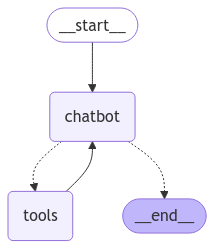

In [ ]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import SystemMessage, HumanMessage

## --- Tools --- ##
@tool
def suma(a: int, b: int) -> int:
    """Sum two numbers."""
    return a + b

@tool
def duplicar(sum: int) -> int:
    """Double a sum."""
    return sum * 2

tools = [suma, duplicar]
llm_with_tools = llama3_3.bind_tools(tools, parallel_tool_calls=False)
## --------------------- ##

## --- State --- ##
# let's use the predefined MessagesState for this example
from langgraph.graph import MessagesState

## -------------- ##

## --- Nodes --- ##
def chatbot(state: MessagesState) -> MessagesState:
    'Chat model that determines if a tool should be called or not to answer the query'
    # assume the first message is the user's query
    prompt = state['messages']

    # (optional) We can specify a system prompt to condition the model's response style
    sys_prompt = SystemMessage(content="You are a math assistant that makes arithmetic calculations given two numbers")
    prompt = [sys_prompt] + prompt
    return {'messages': [llm_with_tools.invoke(prompt)]}

tool_node = ToolNode(tools)
## ------------- ##

## --- Graph --- ##
graph = StateGraph(MessagesState)

graph.add_node("chatbot", chatbot)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chatbot")
graph.add_edge("tools", "chatbot")
graph.add_conditional_edges("chatbot",
                            # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                            # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
                            tools_condition
                            )
## ------------- ##

workflow = graph.compile()
visualize_workflow(workflow)

In [ ]:
messages = [HumanMessage(content="what is double the sum between 5 and 3?")]
messages = workflow.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

what is double the sum between 5 and 3?
================================== Ai Message ==================================
Tool Calls:
  suma (call_f2q1)
 Call ID: call_f2q1
  Args:
    a: 5
    b: 3
================================= Tool Message =================================
Name: suma

8
================================== Ai Message ==================================
Tool Calls:
  duplicar (call_3mt5)
 Call ID: call_3mt5
  Args:
    sum: 8
================================= Tool Message =================================
Name: duplicar

16
================================== Ai Message ==================================

The sum between 5 and 3 is 8, and double that sum is 16.


Well done! You have created your own autonomous flow (Agentic workflow). This particular design, where the chatbot iterates with a tools node, is called Reason-and-Act (ReAct).

Inspired by the [Chain-of-Thought (CoT)](https://arxiv.org/abs/2201.11903) prompting technique, ReAct was [first proposed in 2023](https://arxiv.org/pdf/2210.03629) as an ingenious prompting technique to improve the ability of LLM-powered chatbots to respond to complex queries. In simple terms, "reasoning" means a series of thoughts and "action" means making a reasonable decision. Combined, the idea is that a thought can always be followed by some actionable decision which, when executed, produces an observation. This results in a Thought-Action-Observation chain that "creates, maintains, and dynamically adjusts high-level plans for acting while interacting with the external environment".

This technique became the first Agentic (or autonomous) workflow design. We think of "interacting with the external environment" as the availability of Tools, and the dynamic feature is achieved through a self-referential loop between an LLM and its Tools. Today, you'll learn how to implement such a ReAct Agentic design using a popular development framework called LangGraph.

To conclude this section, let's develop a more useful ReAct Agent that makes use of the [Yahoo Finance API](https://pypi.org/project/yfinance/) to obtain financial data for a public company or mutual fund.


> If you are interested, I wrote a [Medium blog post](https://medium.com/@agbonorino/finance-react-agent-with-langgraph-6a6553039900) with some background information on the state of Agents in the market and narrative context around this application with yahoo finance.



In [ ]:
%pip install yfinance --quiet

In [ ]:
# let's use the API to fetch the top holdings of a mutual fund and generate a report given the business summary of the top 2 holdings
# first, get a proof of concept working before writing any tools.
import yfinance as yf

ETF_data = yf.Ticker("URA").funds_data
ETF_description = ETF_data.description
ETF_top_holdings = ETF_data.top_holdings
ETF_sector_weights = ETF_data.sector_weightings

print(f"ETF description: {ETF_description}\n")
print(f"ETF top holdings: {ETF_top_holdings}\n")
print(f"ETF sector weights:\n")
pp.pprint(ETF_sector_weights)

ETF description: The fund invests at least 80% of its total assets in the securities of the underlying index and in American Depositary Receipts ("ADRs") and Global Depositary Receipts ("GDRs") based on the securities in the underlying index. The underlying index is designed to measure broad based equity market performance of global companies involved in the uranium industry. The fund is non-diversified.

ETF top holdings:                                           Name  Holding Percent
Symbol                                                         
CCO.TO                             Cameco Corp         0.254815
NXE.TO                       NexGen Energy Ltd         0.065868
UEC                        Uranium Energy Corp         0.054433
KAP     National Atomic Co Kazatomprom JSC ADR         0.050226
PDN.AX                      Paladin Energy Ltd         0.033586
DML.TO                      Denison Mines Corp         0.032565
OKLO                   Oklo Inc Class A Shares         0.0298

In [ ]:
tickers_data = yf.Tickers("CCO.TO NXE.TO")
tickers_data.tickers["CCO.TO"].info['longBusinessSummary']

'Cameco Corporation provides uranium for the generation of electricity. It operates through Uranium, Fuel Services, Westinghouse segments. The Uranium segment is involved in the exploration for, mining, and milling, purchase, and sale of uranium concentrate. The Fuel Services segment engages in the refining, conversion, and fabrication of uranium concentrate, as well as the purchase and sale of conversion services. This segment also produces CANDU reactor fuel bundles and other reactor components. The company offers nuclear fuel processing services. The Westinghouse segment engages in the manufacture of nuclear reactor technology original equipment. This segment provides products and services to commercial utilities and government agencies; and outage and maintenance services, engineering support, instrumentation and controls equipment, plant modification, and components and parts to nuclear reactors. It sells its uranium and fuel services to nuclear utilities in the Americas, Europe, 

In [ ]:
descriptions = []
for ticker in tickers_data.tickers:
    descriptions.append(f"{ticker} Business Summary:\n\n{tickers_data.tickers[ticker].info['longBusinessSummary']}\n\n")

response = "".join(descriptions)
print(response)

CCO.TO Business Summary:

Cameco Corporation provides uranium for the generation of electricity. It operates through Uranium, Fuel Services, Westinghouse segments. The Uranium segment is involved in the exploration for, mining, and milling, purchase, and sale of uranium concentrate. The Fuel Services segment engages in the refining, conversion, and fabrication of uranium concentrate, as well as the purchase and sale of conversion services. This segment also produces CANDU reactor fuel bundles and other reactor components. The company offers nuclear fuel processing services. The Westinghouse segment engages in the manufacture of nuclear reactor technology original equipment. This segment provides products and services to commercial utilities and government agencies; and outage and maintenance services, engineering support, instrumentation and controls equipment, plant modification, and components and parts to nuclear reactors. It sells its uranium and fuel services to nuclear utilities 

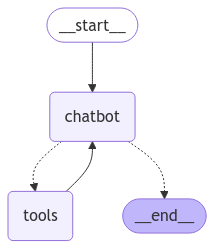

In [ ]:
import yfinance as yf
from datetime import date, timedelta
import pandas as pd

## --- Tools --- ##
@tool(response_format='content_and_artifact')
def fund_top_holdings(ticker: str) -> Tuple[str, dict]:
    '''
    Function for fetching the top 2 holdings of a mutual fund listed in yahoo finance,
    The input ticker must be a valid ticker symbol for a mutual fund.
    '''
    try:
        ETF_data = yf.Ticker(ticker).funds_data
        ETF_top_holdings = ETF_data.top_holdings
        top_2_holdings = f"{ETF_top_holdings.iloc[:2, 0].to_dict()}"
    except:
        raise ValueError(f"Ticker {ticker} not found")

    return top_2_holdings, ETF_top_holdings.to_dict()

@tool(response_format='content')
def top_holdings_report(tickers: str) -> str:
    '''
    Function to use get the description of the top 2 holdings of a mutual fund listed in yahoo finance.
    The input tickers must be a single string with the ticker symbols separated by a whitespace. For example, "MSFT AAPL".
    '''
    try:
        tickers_data = yf.Tickers(tickers)

        descriptions = []
        for ticker in tickers_data.tickers:
            descriptions.append(f"{ticker} Business Summary:\n\n{tickers_data.tickers[ticker].info['longBusinessSummary']}\n\n")

        response = "".join(descriptions)

    except:
        raise ValueError(f"Ticker {tickers} not found")

    return response

tools = [fund_top_holdings, top_holdings_report]
llm_with_tools = llama3_3.bind_tools(tools, parallel_tool_calls=False)
## --------------------- ##

## --- State --- ##
from langgraph.graph import MessagesState

## -------------- ##

## --- Nodes --- ##
def chatbot(state: MessagesState) -> MessagesState:
    'Function to call the model that will determine if any tool calls are necessary and generate a response'

    prompt = state['messages']
    sys_prompt = SystemMessage(content="You are an experience financial analyst and mutual fund expert")
    prompt = [sys_prompt] + prompt

    return {'messages': [llm_with_tools.invoke(prompt)]}

tool_node = ToolNode(tools)
## ------------- ##

## --- Graph --- ##
graph = StateGraph(MessagesState)

graph.add_node("chatbot", chatbot)
graph.add_node("tools", tool_node)

graph.add_edge(START, "chatbot")
graph.add_edge("tools", "chatbot")
graph.add_conditional_edges("chatbot",
                            # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
                            # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
                            tools_condition
                            )
## ------------- ##

workflow = graph.compile()
visualize_workflow(workflow)

In [ ]:
query = {"messages": ("human", "What is the focus of the top 2 holdings of URA? What is the consensus outlook for their industry overall? Provide a detailed analysis")}
messages = workflow.invoke(query)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the focus of the top 2 holdings of URA? What is the consensus outlook for their industry overall? Provide a detailed analysis
================================== Ai Message ==================================
Tool Calls:
  fund_top_holdings (call_wpmk)
 Call ID: call_wpmk
  Args:
    ticker: URA
================================= Tool Message =================================
Name: fund_top_holdings

{'CCO.TO': 'Cameco Corp', 'NXE.TO': 'NexGen Energy Ltd'}
================================== Ai Message ==================================

The top 2 holdings of the URA mutual fund are Cameco Corp (CCO.TO) and NexGen Energy Ltd (NXE.TO), both of which are companies in the uranium mining industry. 

The consensus outlook for the uranium mining industry is positive, driven by increasing demand for nuclear energy and declining uranium production. Many analysts believe that the industry is poised for growth,

In [ ]:
from textwrap import TextWrapper
wrapper = TextWrapper(width=140)

print(wrapper.fill(messages['messages'][-1].content))

The top 2 holdings of the URA mutual fund are Cameco Corp (CCO.TO) and NexGen Energy Ltd (NXE.TO), both of which are companies in the
uranium mining industry.   The consensus outlook for the uranium mining industry is positive, driven by increasing demand for nuclear energy
and declining uranium production. Many analysts believe that the industry is poised for growth, with some predicting a significant increase
in uranium prices over the next few years.  Cameco Corp, one of the top holdings of URA, is a leading uranium producer with a strong track
record of operational excellence and a diversified portfolio of assets. The company has a significant presence in the Athabasca Basin, one
of the world's premier uranium-producing regions, and is well-positioned to benefit from the expected increase in demand for uranium.
NexGen Energy Ltd, the other top holding of URA, is a junior uranium mining company with a focus on the development of its Arrow deposit in
the Athabasca Basin. The company 

In [ ]:
# test 2
query = {"messages": ("human", "What is the consensus outlook for the top holdings of VTI?")}
messages = workflow.invoke(query)
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is the consensus outlook for the top holdings of VTI?
================================== Ai Message ==================================
Tool Calls:
  fund_top_holdings (call_45cm)
 Call ID: call_45cm
  Args:
    ticker: VTI
================================= Tool Message =================================
Name: fund_top_holdings

{'AAPL': 'Apple Inc', 'MSFT': 'Microsoft Corp'}
================================== Ai Message ==================================
Tool Calls:
  top_holdings_report (call_ct12)
 Call ID: call_ct12
  Args:
    tickers: AAPL MSFT
================================= Tool Message =================================
Name: top_holdings_report

AAPL Business Summary:

Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. The company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of

In [ ]:
print(wrapper.fill(messages['messages'][-1].content))

The consensus outlook for the top holdings of VTI, which are Apple Inc. (AAPL) and Microsoft Corp (MSFT), is positive. Both companies have a
strong track record of innovation and have been able to maintain their market leadership positions in their respective industries. Apple's
ecosystem of products and services, including the iPhone, Mac, and Apple Watch, continues to drive growth and loyalty among customers.
Microsoft's cloud-based offerings, including Azure and Office 365, have been gaining traction and are expected to continue to drive growth
for the company. Overall, the outlook for these two companies is positive, and they are expected to continue to be leaders in their
respective industries.


In [ ]:
# double check
ETF_data = yf.Ticker("VTI").funds_data
ETF_description = ETF_data.description
ETF_top_holdings = ETF_data.top_holdings
ETF_sector_weights = ETF_data.sector_weightings

print(f"ETF description: {ETF_description}\n")
print(f"ETF top holdings: {ETF_top_holdings}\n")
print(f"ETF sector weights:\n")
pp.pprint(ETF_sector_weights)

ETF description: The fund employs an indexing investment approach designed to track the performance of the index, which represents approximately 100% of the investable U.S. stock market and includes large-, mid-, small-, and micro-cap stocks. It invests by sampling the index, meaning that it holds a broadly diversified collection of securities that, in the aggregate, approximates the full index in terms of key characteristics. The fund is non-diversified.

ETF top holdings:                                   Name  Holding Percent
Symbol                                                 
AAPL                         Apple Inc         0.066656
MSFT                    Microsoft Corp         0.055184
NVDA                       NVIDIA Corp         0.055017
AMZN                    Amazon.com Inc         0.036560
META        Meta Platforms Inc Class A         0.022476
GOOGL             Alphabet Inc Class A         0.019477
TSLA                         Tesla Inc         0.019403
AVGO             